# Install

In [1]:
!pip install causaldata --quiet
!pip install pingouin --quiet

# Imports

In [2]:
from graphviz import Digraph
from pingouin import partial_corr
from sklearn.linear_model import LinearRegression
import causaldata
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import statsmodels.api as sm

# Load data, train models, measure metrics

In [3]:
df = pd.concat([
    causaldata.close_college.load_pandas().exog,
    causaldata.close_college.load_pandas().endog], axis=1).dropna().rename({
        "lwage": "Wage",
        "educ": "Education",
        "exper": "Experience",
        "black": "Black",
        "south": "South",
        "married": "Married",
        "smsa": "Urban",
        "nearc4": "NearCollege"}, axis=1)

target = "Wage"
features = [c for c in df.columns if c != target]

# Elaborate

In [4]:
results = pd.DataFrame(columns=["c-pe", "c-ci", "pc-pe", "pc-ci"])

for feature in features:
    results.loc[feature, ["c-pe", "c-ci"]] = partial_corr(
        data=df, x=feature, y=target).loc["pearson",["r","CI95%"]].tolist()
    results.loc[feature, ["pc-pe", "pc-ci"]] = partial_corr(
        data=df, x=feature, y=target, covar=[f for f in features if f != feature]).loc["pearson",["r","CI95%"]].tolist()

sm_ols = sm.OLS(df[target], sm.add_constant(df[features])).fit()
results.loc[features,"lr-pe"] = sm_ols.params[features]
results.loc[features,"lr-ci"] = sm_ols.conf_int(alpha=0.05).loc[features,:].apply(lambda row: row.round(2).tolist(), axis=1)

sorted_features_c_pe = results.sort_values("c-pe", key=np.abs, ascending=False).index
sorted_features_pc_pe = results.sort_values("pc-pe", key=np.abs, ascending=False).index

In [5]:
counter = 0
recursive_pc_results = pd.DataFrame(columns=["x","covar","corr"])

for x_feature in features:
    covar_features = []
    remaining_features = [f for f in features if f != x_feature]

    for i in range(len(features)):
        recursive_pc_results.loc[counter, "x"] = x_feature

        if i == 0:
            recursive_pc_results.loc[counter, "covar"] = "[]"
            recursive_pc_results.loc[counter, "corr"] = partial_corr(
                data=df, x=x_feature, y=target, covar=[]).loc["pearson","r"]

        else:
            pcs = pd.Series()
            for feature in remaining_features:
                pcs[feature] = partial_corr(
                    data=df, x=x_feature, y=target, covar=covar_features + [feature]).loc["pearson","r"]
            selected_feature = (pcs - recursive_pc_results["corr"].iloc[-2]).abs().idxmax()
            covar_features.append(selected_feature)
            remaining_features = [c for c in remaining_features if c != selected_feature]
            recursive_pc_results.loc[counter, "covar"] = "[" + ",".join(covar_features) + "]"
            recursive_pc_results.loc[counter, "corr"] = pcs[selected_feature]

        counter += 1

In [6]:
corr = pd.concat([
    df[["Education","Experience","Wage"]],
    pd.Series(
        df["Experience"] -
        LinearRegression().fit(X=df[["Education"]], y=df["Experience"]).predict(X=df[["Education"]]),
        index=df.index,
        name="Experience [residuals]",
    ),
    pd.Series(
        df["Wage"] -
        LinearRegression().fit(X=df[["Education"]], y=df["Wage"]).predict(X=df[["Education"]]),
        index=df.index,
        name="Wage [residuals]",
    ),
], axis=1).corr()

# Show

In [7]:
lr_display = results.loc[sorted_features_c_pe, ["lr-pe","lr-ci"]]
lr_display["lr-pe"] = lr_display["lr-pe"].round(2)
lr_display.columns = ["Parameter", "Confidence interval (95%)"]

lr_display

,Parameter,Confidence interval (95%)
Education,0.07,"[0.06, 0.08]"
Black,-0.17,"[-0.2, -0.13]"
South,-0.13,"[-0.16, -0.1]"
Urban,0.17,"[0.14, 0.2]"
Married,-0.04,"[-0.04, -0.03]"
NearCollege,0.02,"[-0.01, 0.05]"
Experience,0.03,"[0.03, 0.04]"


<ipython-input-8-a6cfae1f63eb>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[["c-ci","pc-ci"]].applymap(lambda x: x[0]).min().min(),
<ipython-input-8-a6cfae1f63eb>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[["c-ci","pc-ci"]].applymap(lambda x: x[1]).max().max())


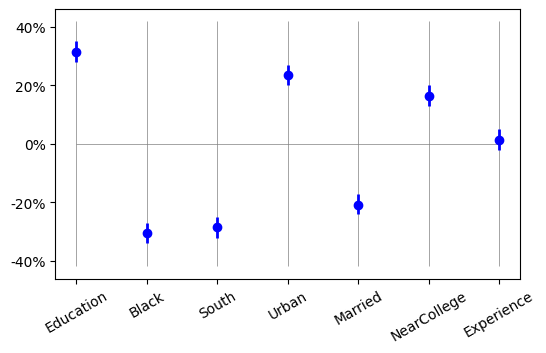

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.5))

clim = (
    results[["c-ci","pc-ci"]].applymap(lambda x: x[0]).min().min(),
    results[["c-ci","pc-ci"]].applymap(lambda x: x[1]).max().max())
clim = -np.max(np.abs(clim)), np.max(np.abs(clim))
cdiff = clim[1] - clim[0]
ylim = clim[0] - cdiff*.05, clim[1] + cdiff*.05
xlim = 0, len(features) - 1

ax.hlines(0, xlim[0], xlim[1], lw=.5, color="grey", zorder=-1)

for enum, feature in enumerate(sorted_features_c_pe):
    ax.vlines(enum, ylim[0], ylim[1], lw=.5, color="grey")
    ax.vlines(enum, results.loc[feature,"c-ci"][0], results.loc[feature,"c-ci"][1], lw=2, zorder=100, color="blue")
    ax.scatter(enum, results.loc[feature,"c-pe"], color="blue", zorder=100)

ax.set_xticks(range(enum+1));
ax.set_xticklabels(sorted_features_c_pe, rotation=30)
ax.set_yticks(np.linspace(-.4,.4,5))
ax.set_yticklabels([f"{y:.0%}" for y in np.linspace(-.4,.4,5)])

fig.savefig(f"simple_correlation.png", dpi=200, bbox_inches="tight")

<ipython-input-9-4d926735e232>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[["c-ci","pc-ci"]].applymap(lambda x: x[0]).min().min(),
<ipython-input-9-4d926735e232>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[["c-ci","pc-ci"]].applymap(lambda x: x[1]).max().max())


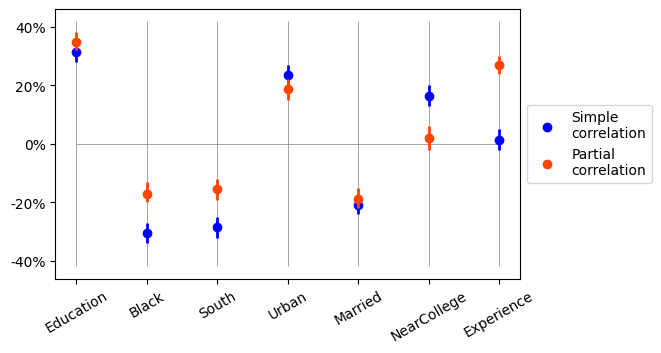

In [9]:
fig, ax = plt.subplots(figsize=(6, 3.5))

sorted_features = results.sort_values("c-pe", key=np.abs, ascending=False).index
clim = (
    results[["c-ci","pc-ci"]].applymap(lambda x: x[0]).min().min(),
    results[["c-ci","pc-ci"]].applymap(lambda x: x[1]).max().max())
clim = -np.max(np.abs(clim)), np.max(np.abs(clim))
cdiff = clim[1] - clim[0]
ylim = clim[0] - cdiff*.05, clim[1] + cdiff*.05
xlim = 0, len(sorted_features)-1

ax.hlines(0, xlim[0], xlim[1], lw=.5, color="grey", zorder=-1)

for enum, feature in enumerate(sorted_features):
    ax.vlines(enum, ylim[0], ylim[1], lw=.5, color="grey")
    ax.vlines(enum, results.loc[feature,"c-ci"][0], results.loc[feature,"c-ci"][1], lw=2, zorder=100, color="blue")
    ax.scatter(enum, results.loc[feature,"c-pe"], color="blue", zorder=100, label="Simple\ncorrelation" if enum == 0 else None)
    ax.vlines(enum, results.loc[feature,"pc-ci"][0], results.loc[feature,"pc-ci"][1], lw=2, zorder=100, color="orangered")
    ax.scatter(enum, results.loc[feature,"pc-pe"], color="orangered", zorder=100, label="Partial\ncorrelation" if enum == 0 else None)

ax.set_xticks(range(enum+1));
ax.set_xticklabels(sorted_features, rotation=30)
ax.set_yticks(np.linspace(-.4,.4,5))
ax.set_yticklabels([f"{y:.0%}" for y in np.linspace(-.4,.4,5)])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.savefig(f"simple_and_partial_correlation.png", dpi=200, bbox_inches="tight")

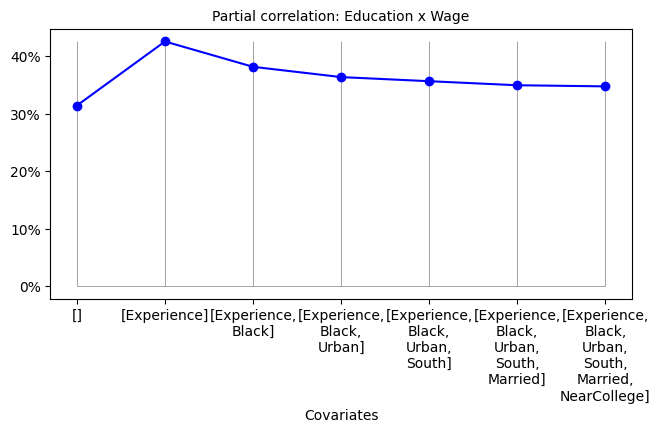

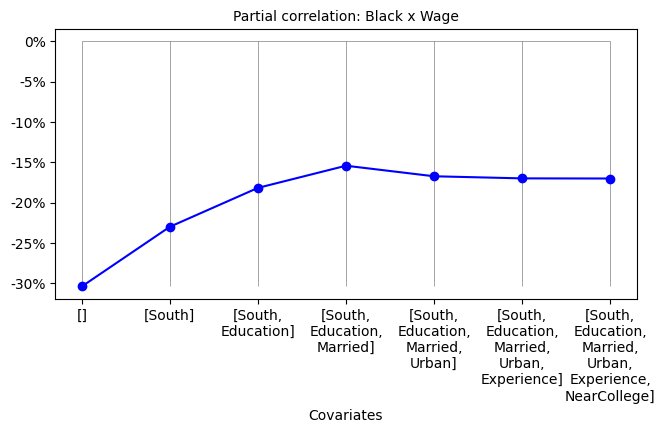

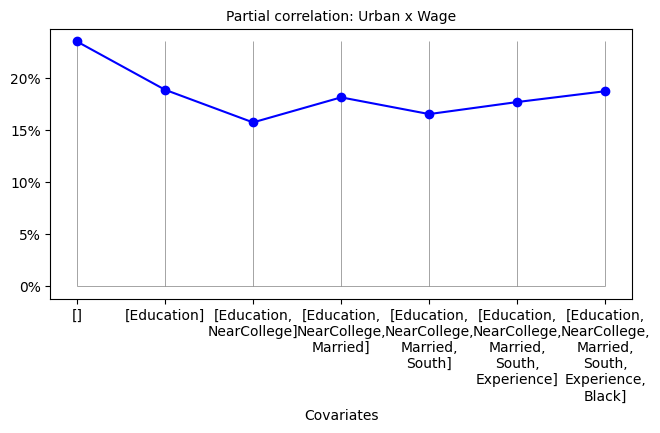

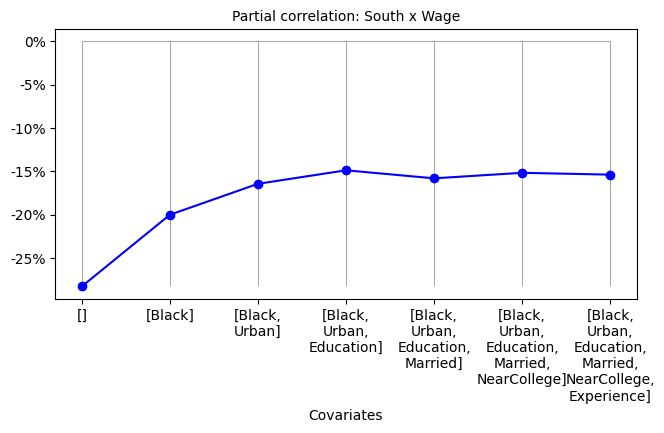

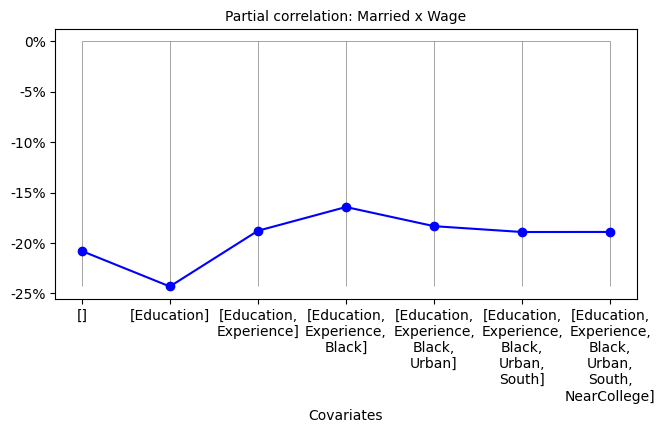

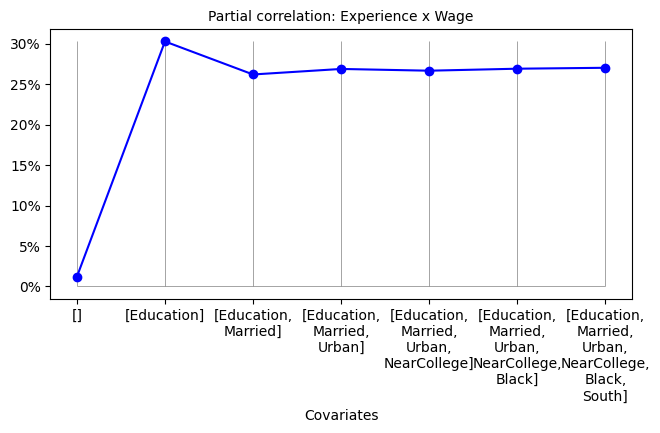

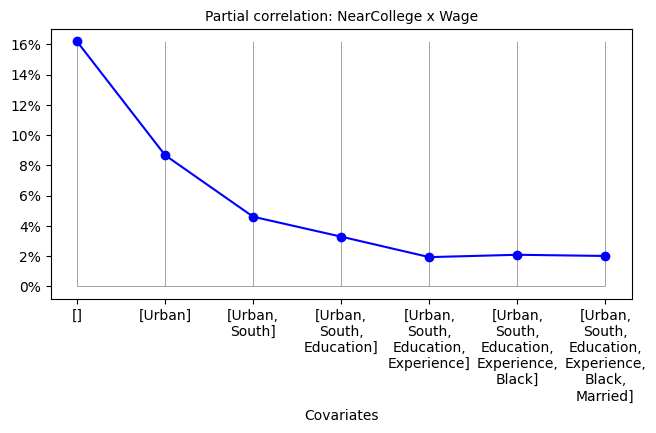

In [10]:
for x_feature in features:

    temp = recursive_pc_results.query(f"x == '{x_feature}'")

    fig, ax = plt.subplots(figsize=(7.5, 3.5))

    ax.hlines(0, 0, 6, lw=.5, color="grey")

    for enum in range(len(temp)):
        ax.vlines(enum, min(temp["corr"].min(), 0), max(temp["corr"].max(), 0), lw=.5, color="grey")

    ax.plot(range(len(features)), temp["corr"], color="blue", zorder=100)
    ax.scatter(range(len(features)), temp["corr"], color="blue", zorder=100)
    yticks = ax.get_yticks()[1:-1]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.0%}" for y in yticks])
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(temp["covar"].apply(lambda s: s.replace(",",",\n")))
    ax.set_xlabel("Covariates")
    ax.set_title(f"Partial correlation: {x_feature} x {target}", fontsize=10)

    fig.savefig(f"recursive_pc_{x_feature}.png", dpi=200, bbox_inches="tight")

In [11]:
dot = Digraph(format="png")
dot.attr(rankdir="LR")
dot.attr(dpi="200")

nodes = ["Education", "Experience", "Wage"]
for node in nodes:
    dot.node(node, node)

for i, node1 in enumerate(nodes):
    for j, node2 in enumerate(nodes):
        if i < j:
            weight = corr.loc[node1, node2]
            label = f"{weight:.2f}"
            dot.edge(node1, node2, label=label, dir="both")

dot.render("digraph")

'digraph.png'

In [12]:
dot = Digraph(format="png")
dot.attr(rankdir="LR")
dot.attr(dpi="200")

nodes = ["Education", "Experience", "Wage", "Experience\n[residuals]", "Wage\n[residuals]"]
for node in nodes:
    dot.node(node, node)

for node1, node2 in [
    ("Education", "Experience"),
    ("Education", "Wage"),
    ("Experience", "Wage"),
    ("Education", "Experience\n[residuals]"),
    ("Education", "Wage\n[residuals]"),
    ("Experience\n[residuals]", "Wage\n[residuals]"),
]:
    weight = corr.loc[node1.replace("\n", " "), node2.replace("\n", " ")]
    label = f"{weight:.2f}"
    dot.edge(node1, node2, label=label, dir="both")

dot.render("digraph_with_residuals")

'digraph_with_residuals.png'

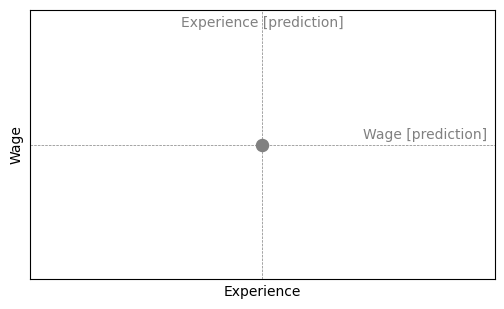

In [13]:
fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(0, 0, color="grey", s=75)
ax.hlines(0, -1, 1, color="grey", ls="--", lw=.5)
ax.vlines(0, -1, 1, color="grey", ls="--", lw=.5)
ax.annotate("Wage [prediction]", (.7, .07), ha="center", va="center", color="grey")
ax.annotate("Experience [prediction]", (0, .9), ha="center", va="center", color="grey")

ax.set_xlabel("Experience")
ax.set_ylabel("Wage")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

fig.savefig(f"lr_prediction.png", dpi=200, bbox_inches="tight")

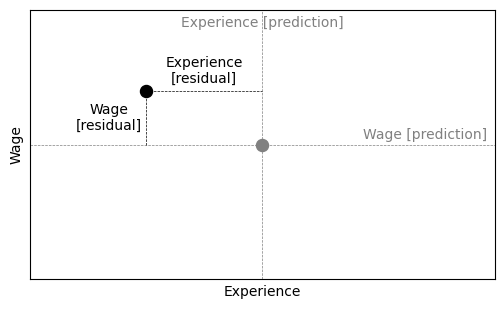

In [14]:
fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(0, 0, color="grey", s=75)
ax.hlines(0, -1, 1, color="grey", ls="--", lw=.5)
ax.vlines(0, -1, 1, color="grey", ls="--", lw=.5)
ax.annotate("Wage [prediction]", (.7, .07), ha="center", va="center", color="grey")
ax.annotate("Experience [prediction]", (0, .9), ha="center", va="center", color="grey")
ax.scatter(-.5, .4, color="black", s=75)
ax.hlines(.4, -.5, 0, color="black", ls="--", lw=.5)
ax.vlines(-.5, .4, 0, color="black", ls="--", lw=.5)
ax.annotate("Experience\n[residual]", (-.25, .55), ha="center", va="center", color="black")
ax.annotate("Wage\n[residual]", (-.66, .2), ha="center", va="center", color="black")

ax.set_xlabel("Experience")
ax.set_ylabel("Wage")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

fig.savefig(f"lr_residual.png", dpi=200, bbox_inches="tight")

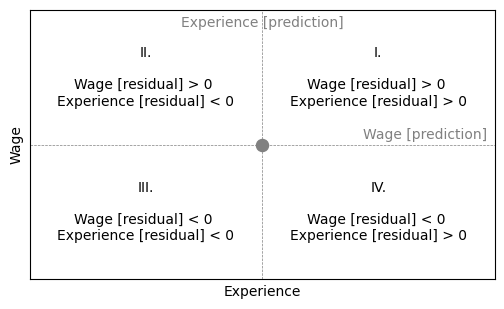

In [15]:
fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(0, 0, color="grey", s=75)
ax.hlines(0, -1, 1, color="grey", ls="--", lw=.5)
ax.vlines(0, -1, 1, color="grey", ls="--", lw=.5)
ax.annotate("Wage [prediction]", (.7, .07), ha="center", va="center", color="grey")
ax.annotate("Experience [prediction]", (0, .9), ha="center", va="center", color="grey")
ax.annotate("I.\n\nWage [residual] > 0 \nExperience [residual] > 0", (.5,.5), ha="center", va="center")
ax.annotate("II.\n\nWage [residual] > 0 \nExperience [residual] < 0", (-.5,.5), ha="center", va="center")
ax.annotate("III.\n\nWage [residual] < 0 \nExperience [residual] < 0", (-.5,-.5), ha="center", va="center")
ax.annotate("IV.\n\nWage [residual] < 0 \nExperience [residual] > 0", (.5,-.5), ha="center", va="center")

ax.set_xlabel("Experience")
ax.set_ylabel("Wage")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

fig.savefig(f"lr_prediction_and_residual.png", dpi=200, bbox_inches="tight")

# Pad images

In [16]:
def pad_or_crop_image(input_path, target_size, output_path):
    img = PIL.Image.open(input_path)
    original_width, original_height = img.size
    target_width, target_height = target_size

    if target_width is None:
        target_width = original_width
    if target_height is None:
        target_height = original_height

    if target_width < original_width or target_height < original_height:
        left = (original_width - target_width) // 2
        top = (original_height - target_height) // 2
        right = left + target_width
        bottom = top + target_height
        img = img.crop((left, top, right, bottom))

    new_width, new_height = img.size

    if new_width < target_width or new_height < target_height:
        padding_left = (target_width - new_width) // 2
        padding_top = (target_height - new_height) // 2
        padding_right = target_width - new_width - padding_left
        padding_bottom = target_height - new_height - padding_top

        img = PIL.ImageOps.expand(img, border=(padding_left, padding_top, padding_right, padding_bottom), fill='white')

    img.save(output_path, format='PNG')

In [17]:
def trim_white_columns(input_path, output_path):
    image = PIL.Image.open(image_path).convert("RGBA")
    pixels = image.load()

    width, height = image.size

    left = 0
    right = width - 1

    white_pixel = (255, 255, 255, 255)

    for x in range(width):
        if any(pixels[x, y] != white_pixel for y in range(height)):
            left = x
            break

    for x in range(width - 1, -1, -1):
        if any(pixels[x, y] != white_pixel for y in range(height)):
            right = x
            break

    image.crop((left, 0, right + 1, height)).save(output_path)

In [18]:
image_paths = []

for image_path in os.listdir():
    if image_path.endswith('.png'):
        image_paths.append(image_path)

In [19]:
max_width = 0
max_width_image_path = ""
trimmed_image_paths = []

for image_path in image_paths:
    trim_white_columns(
        input_path=image_path,
        output_path=f"trim_{image_path}")
    trim_img = PIL.Image.open(f"trim_{image_path}")
    trimmed_image_paths.append(f"trim_{image_path}")
    width = trim_img.size[0]
    if width > max_width:
        max_width = width
        max_width_image_path = image_path

In [20]:
for image_path in trimmed_image_paths:
    pad_or_crop_image(
        input_path=image_path,
        target_size=(max_width, None),
        output_path=image_path.replace("trim_","final_"))